In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_RecCir.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")
include(main_path*"Module/Objective_single.jl")

gs_p_optimize (generic function with 3 methods)

In [2]:
L = 600
h1 = 600
h2 = 200
rd = 100
rs = 10
rt = 150
dpml = 300

res = 50
l1 = L/res
l2 = l1/3

hrd = [0, h1/2]
meshfile = "geometry.msh"
geo_param = RecCirGeometry(L, h1, h2, rt, rd, rs, dpml, l1, l2)
MeshGenerator(geo_param, meshfile)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 6
Info    : Reconstructing periodicity for curve connection 3 - 5
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Meshing curve 13 (Circle)
Info    : Meshing curve 2 (Line) as a copy of 6
Info    : Meshing curve 3 (Line) as a copy of 5
Info    : Done meshing 1D (0.001349 s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal)
Info    : Meshing surface 2 (Plane, Frontal)
Info    : Meshing surface 3 (Plane, Frontal)
Info    : Meshing surface 4 (Plane, Frontal)
Info    : Meshing surface 5 (Plane, Fronta

In [9]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = [0.02 * L, 0.02 * L]  # Filter radius
β = 80.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1e4

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = false          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])


control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)



Info    : Reading 'geometry.msh'...
Info    : 31 entities
Info    : 26478 nodes
Info    : 53238 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 4688, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 7)

In [10]:

material = "Cu"
n_λ, k_λ = RefractiveIndex(material,main_path,false)
λ1 = 532
λ2 = 548
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = 1
μ = 1
R = 1e-10
LHp=[L/2, h1+h2]   # Start of PML for x,y > 0
LHn=[L/2, 0.1]       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nf, μ, R, dpml, LHp, LHn, 0)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nf, μ, R, dpml, LHp, LHn, 0)

nm1
# N = num_free_dofs(gridap.FE_U)
# kb = 0. * ω1
# p0 = ones(gridap.np)
# pf_vec = pf_p0(p0; control, gridap)
# pfh = FEFunction(gridap.FE_Pf, pf_vec)
# pth = (pf -> Threshold(pf; control)) ∘ pfh

# A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)

# binc(v) = ∫(v)gridap.dΓ_s
# b_inc = assemble_vector(binc, gridap.FE_V)

# u1_vec = A1_mat\b_inc
# u1h = FEFunction(gridap.FE_U, u1_vec)

# A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
# O_mat = MatrixOc(ω2, nf^2; gridap)

# braman(v) = ∫((x->GaussianD(x, hrd, [2,2]))*(∇(v) ⋅ ∇(u1h)))gridap.dΩ
# b_raman = assemble_vector(braman, gridap.FE_V)
# v2_vec = A2_mat' \ b_raman
# v2h = FEFunction(gridap.FE_U, v2_vec)

# @show gvalue = v2_vec'*O_mat*v2_vec

# #fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
# maxv = maximum(abs.(u1_vec))/1
# fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
# Colorbar(fig[1,2], plt)
# ax.title = "Design Shape"
# ax.aspect = AxisAspect((L+2*dpml)/(h1+h2+2*dpml))
# #ax.aspect = AxisAspect(L/(h1))
# #limits!(ax, -L/2, L/2, 0, h1)
# fig
#0.12931555555555557 + 3.1932im

1.115884476534296 + 2.59557761732852im

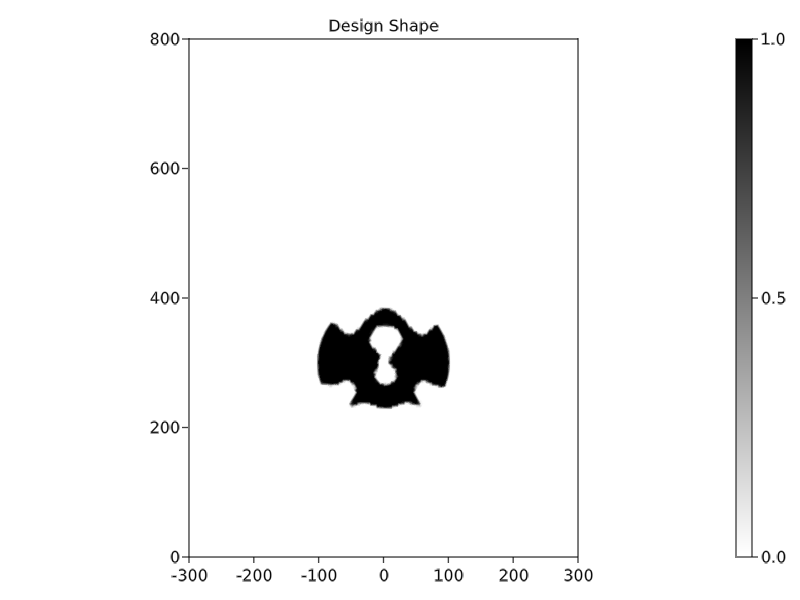

In [14]:
using FileIO
import Images: Gray
# specify the path to your local image file
img_path = "Initial/Rasmus_Raman.png"
img = load(img_path)
data = 1.0 .-Float64.(Gray.(img))
function image_to_function(x, data, Lx, Ly)
    Nx, Ny = size(data)
    xi = Int(round((x[1]/Lx + 0.5) * Nx))
    yi = Ny-Int(round(((x[2]-h1/2)/Ly + 0.5) * Ny))
    if xi > 0 && xi <= Nx && yi > 0 && yi <= Ny
        return data[xi,yi]
    else
        return 0.0
    end
end

binit(v) = ∫(v * x->image_to_function(x, data, 280, 280))gridap.dΩ
pc_vec = assemble_vector(binit, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.5] .= 0
p_init[p_init .> 0.5] .= 1

pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(h1+h2))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, h1+h2)
# save("Results/shape.png", fig)
fig

In [15]:
# p_init = ones(gridap.np) * 0.5 + rand(gridap.np) * 1e-2
β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]
# β_list = [80.0, 80.0, 80.0, 80.0, 80.0]

g_opt = 0
for bi = 1 : 7
    β = β_list[bi]
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    if bi == 1
        g_opt, p_opt = gs_p_optimize(p_init, 1e-12, 200; phys1, phys2, control, gridap)
    
    else
        g_opt, p_opt = gs_p_optimize([], 1e-12, 200; phys1, phys2, control, gridap)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 145
numevals = opt.numevals = 200
numevals = opt.numevals = 200
numevals = opt.numevals = 200
numevals = opt.numevals = 200
numevals = opt.numevals = 200
numevals = opt.numevals = 200
g_opt = 0.13326930074247634


0.13326930074247634

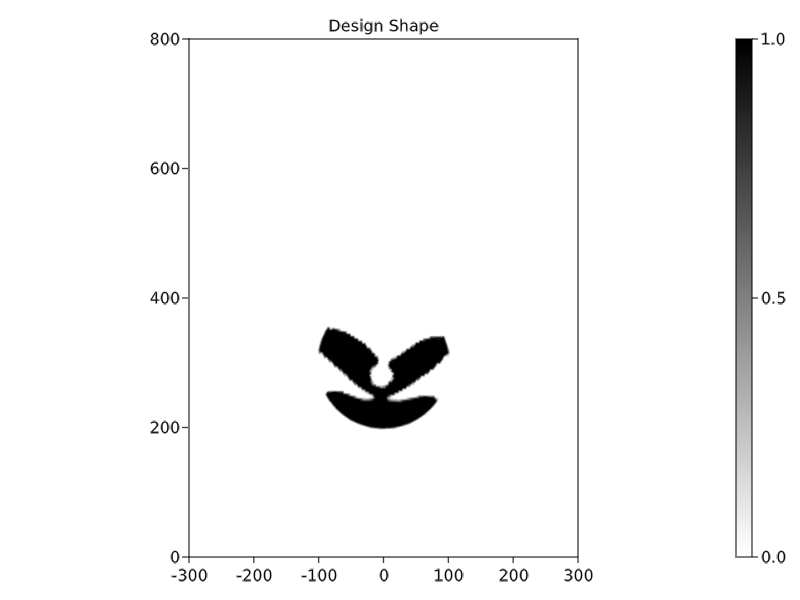

In [16]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(h1+h2))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, h1+h2)
save("Results/shape.png", fig)
fig

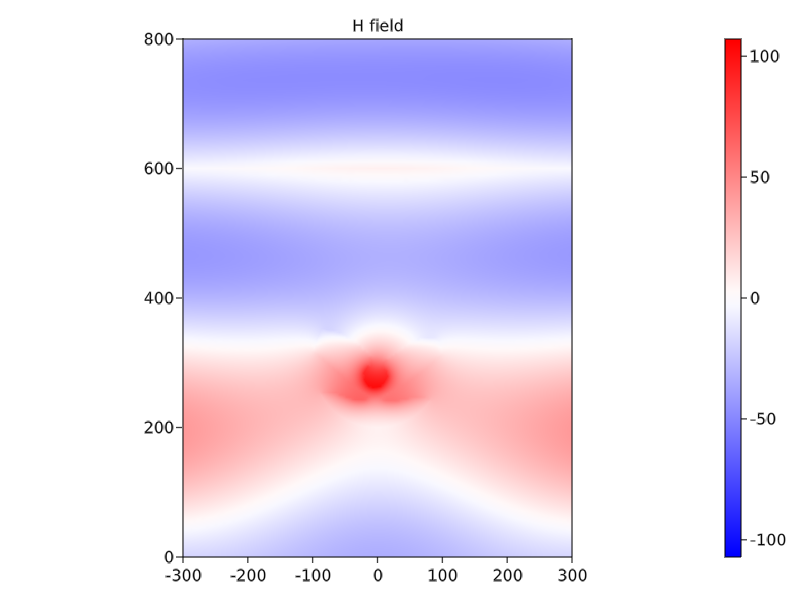

In [17]:
maxv = maximum(abs.(u1_vec))/1
fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
Colorbar(fig[1,2], plt)
ax.title = "H field"
ax.aspect = AxisAspect((L)/(h1+h2))
#ax.aspect = AxisAspect(L/(h1))
limits!(ax, -L/2, L/2, 0, h1+h2)
fig

In [8]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
g0 = gs_p(p0, grad; kb, phys1, phys2, control, gridap)
g1 = gs_p(p0+δp, []; kb, phys1, phys2, control, gridap)
g1-g0, grad'*δp

(-4.860400012421818e-12, -4.860396101008534e-12)